In [112]:
import os
import cv2
import numpy as np
import pandas as pd
from insightface.app import FaceAnalysis

In [113]:
# Configure face models
faceapp = FaceAnalysis(name='buffalo_sc',
                       root='insightface_model',
                       providers=['CPUExecutionProvider'])
faceapp.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.5) # dont set det_thresh<0.2 else duplicate faces may come

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_sc\det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_sc\w600k_mbf.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


## Extract Facial Features and Labels

In [114]:
#os.listdir(path='images')

In [115]:
#os.listdir(path='images\student-Angelina Jolie')

In [158]:
import re
def clean_name(string):
    string = re.sub(r'[^A-Aa-z]',' ', string)
    string=string.upper().strip()
    return string

In [117]:
person_info=[]
listdir = os.listdir(path='images')
for folder in listdir:
    #read role and name from foldee name
    role, name= folder.split('-')
    name = clean_name(name)
    role=clean_name(role)
    
    #path of each image in respective folder
    image_files = os.listdir(path=f'images/{folder}')
    for img_file in image_files:
        path=f'./images/{folder}/{img_file}'

        #Step1: read the image
        img_arr = cv2.imread(path)
        
        #Step2: get the info
        result = faceapp.get(img_arr, max_num=1) #returns list
        if len(result)>0:
            res = result[0]
           
            #Step3: extract facial embedding
            embedding = res['embedding']

            #Step4: save name, role, embedding details in a list
            person_info.append([name, role, embedding])

In [118]:
#person_info

In [119]:
dataframe = pd.DataFrame(person_info)

In [120]:
#print(dataframe)

In [121]:
dataframe = pd.DataFrame(person_info, columns=['Name', 'Role','Facial_Features'])
len(dataframe['Facial_Features']) # Contains 50 items.
len(dataframe['Facial_Features'][0]) # Contains 512 items.
#We need to store these data into REDIS

512

In [122]:
# read test image. We will compare this image with the images in our dataframe
img_test = cv2.imread('test_images/known.jpeg')
#cv2.imshow('ImageView', img_test)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [123]:
res_test = faceapp.get(img_test, max_num=0)
#res_test
for rt in res_test:
    bbox = rt['bbox'].astype(int)
    score = int(rt['det_score']*100)
    embed_test=rt['embedding']

### Search embed_test inside dataframe

In [124]:
x_list = dataframe['Facial_Features'].tolist()
x=np.asarray(x_list)

In [125]:
x.shape

(50, 512)

#### Scikit-learn (Sklearn) is the most useful and robust library for machine learning in Python. 

In [126]:
from sklearn.metrics import pairwise

In [127]:
y= embed_test.reshape(1,512) # same as y= embed_test.reshape(1,-1)
euclidean_distance = pairwise.euclidean_distances(x,y)
manhattan_distance = pairwise.manhattan_distances(x,y)
cosine_similarity = pairwise.cosine_similarity(x,y)

In [128]:
data_search = dataframe.copy()
data_search['euclidean'] = euclidean_distance
data_search['manhattan'] = manhattan_distance
data_search['cosine'] = cosine_similarity
#data_search

In [129]:
import matplotlib.pyplot as plt

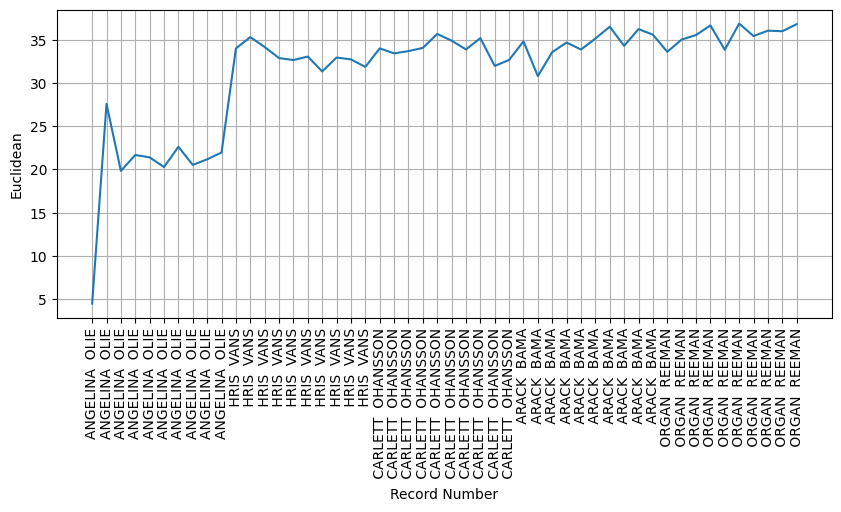

In [130]:
plt.figure(figsize=(10,4))
plt.plot(data_search['euclidean'])
plt.xticks(ticks=list(range(len(data_search['euclidean']))),
                     labels=data_search['Name'],
                     rotation=90)
plt.xlabel('Record Number')
plt.ylabel('Euclidean')
plt.grid()
#plt.show()

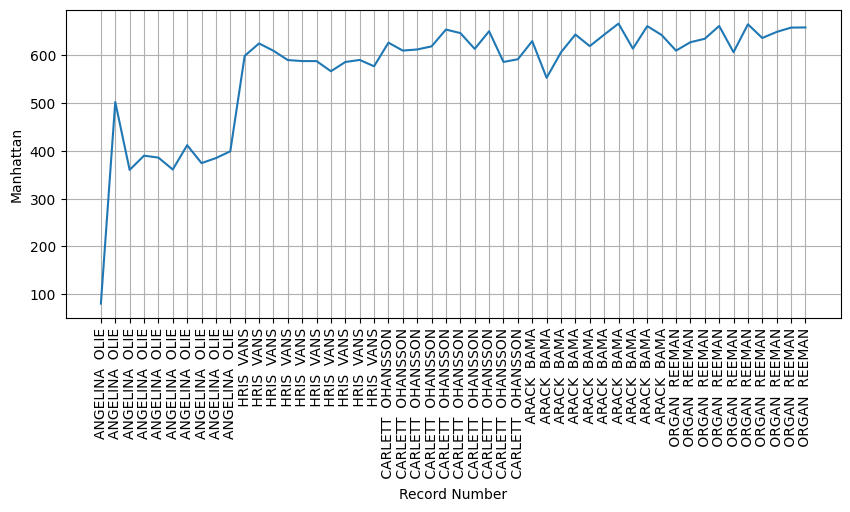

In [131]:
plt.figure(figsize=(10,4))
plt.plot(data_search['manhattan'])
plt.xticks(ticks=list(range(len(data_search['manhattan']))),
                     labels=data_search['Name'],
                     rotation=90)
plt.xlabel('Record Number')
plt.ylabel('Manhattan')
plt.grid()
#plt.show()

Text(0.5, 1.0, 'Cosine Distance')

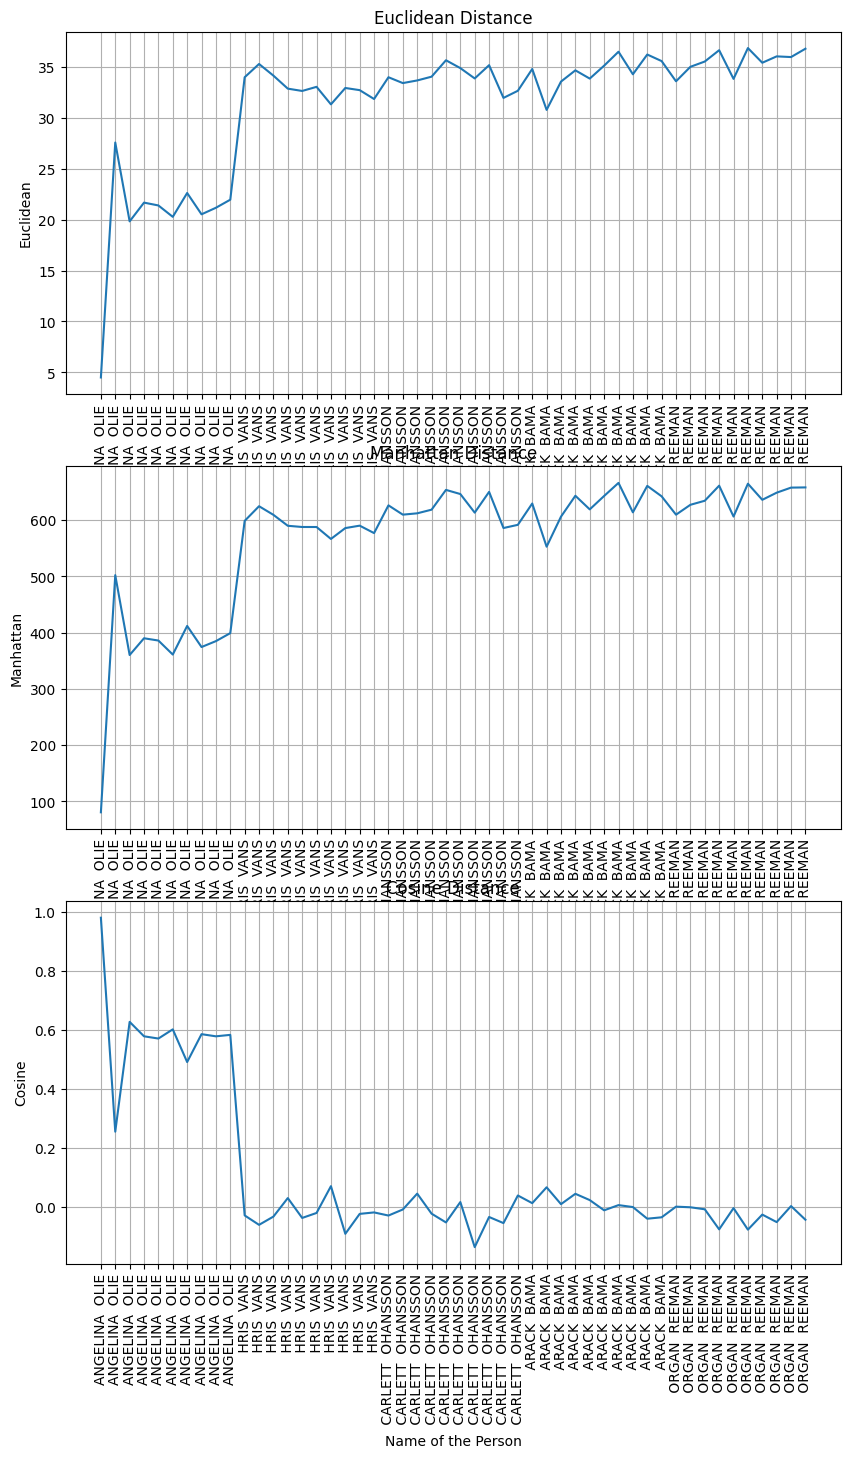

In [132]:
plt.figure(figsize=(10,16))
plt.subplot(3,1,1) #3 Rows 1 Column
plt.plot(data_search['euclidean'])
plt.xticks(ticks=list(range(len(data_search['euclidean']))),
                     labels=data_search['Name'],
                     rotation=90)
plt.xlabel('Name of the Person')
plt.ylabel('Euclidean')
plt.grid()
plt.title('Euclidean Distance')

plt.subplot(3,1,2) #3 Rows 1 Column
plt.plot(data_search['manhattan'])
plt.xticks(ticks=list(range(len(data_search['manhattan']))),
                     labels=data_search['Name'],
                     rotation=90)
plt.xlabel('Name of the Person')
plt.ylabel('Manhattan')
plt.grid()
plt.title('Manhattan Distance')

plt.subplot(3,1,3) #3 Rows 1 Column
plt.plot(data_search['cosine'])
plt.xticks(ticks=list(range(len(data_search['cosine']))),
                     labels=data_search['Name'],
                     rotation=90)
plt.xlabel('Name of the Person')
plt.ylabel('Cosine')
plt.grid()
plt.title('Cosine Distance')
#plt.show()

In [133]:
# Lets define the threshhold for all

In [134]:
#identify the person using euclidean distance
d_eq_optimal = 25
datafilter = data_search.query(f'euclidean < {d_eq_optimal}')
datafilter.reset_index(drop=True, inplace=True)

if len(datafilter)>0:
    argmin = datafilter['euclidean'].argmin()
    #print(datafilter.loc[argmin])
    name, role = datafilter.loc[argmin][['Name', 'Role']]
else:
    name='Unknown'
    role='Unknown'
print(name, role)    

ANGELINA  OLIE STUDENT


In [135]:
#identify the person using manhattan distance
d_man_optimal = 450
datafilter = data_search.query(f'manhattan < {d_man_optimal}')
datafilter.reset_index(drop=True, inplace=True)

if len(datafilter)>0:
    argmin = datafilter['manhattan'].argmin()
    #print(datafilter.loc[argmin])
    name, role = datafilter.loc[argmin][['Name', 'Role']]
else:
    name='Unknown'
    role='Unknown'
print(name, role) 

ANGELINA  OLIE STUDENT


In [136]:
#identify the person using cosine distance
d_cos_optimal = 0.5
datafilter = data_search.query(f'cosine > {d_cos_optimal}')
datafilter.reset_index(drop=True, inplace=True)

if len(datafilter)>0:
    argmax = datafilter['cosine'].argmax()
    #print(datafilter.loc[argmin])
    name, role = datafilter.loc[argmax][['Name', 'Role']]
else:
    name='Unknown'
    role='Unknown'
print(name, role) 

ANGELINA  OLIE STUDENT


#### Save Data in Redis

In [137]:
import redis
#Redit DB End Point: redis-15156.c240.us-east-1-3.ec2.cloud.redislabs.com:15156
#Pwd: liBWWDuDpXcsnXY2DawkFABm7HKIeI4t
hostname='redis-15156.c240.us-east-1-3.ec2.cloud.redislabs.com'
portno=15156
pwd='liBWWDuDpXcsnXY2DawkFABm7HKIeI4t'
r = redis.StrictRedis(host=hostname, port=portno, password=pwd)

In [138]:
r.ping()

True

In [139]:
r.keys()

[b'academy:register', b'KEY', b'MESSAGE', b'a b c', b'KEY1', b'mylist', b'abc']

In [140]:
dataframe_compress=dataframe.groupby(by=['Name','Role']).mean()
dataframe_compress.reset_index(inplace=True)

#### Convert dataframe into Array and save in Numpy Zip Format

In [141]:
xvalues = dataframe_compress.values
col_name = np.array(dataframe_compress.columns)
np.savez('dataframe_student_teachers.npz', xvalues, col_name)

In [142]:
# Load Numpy Zip
file_np = np.load('dataframe_student_teachers.npz', allow_pickle=True)
file_np.files

['arr_0', 'arr_1']

In [143]:
#file_np['arr_0']

In [144]:
df = pd.DataFrame(file_np['arr_0'], columns=file_np['arr_1'])
df

,Name,Role,Facial_Features
0,ARACK BAMA,TEACHER,"[0.94858104, -0.5584052, 0.094820715, -1.27965..."
1,CARLETT OHANSSON,STUDENT,"[0.19131963, -0.48843804, -1.690233, 0.4423967..."
2,HRIS VANS,STUDENT,"[0.7201715, -1.4684149, -0.7781253, -1.4601073..."
3,ORGAN REEMAN,TEACHER,"[0.48535103, -0.6192555, -0.4069932, 1.0687788..."
4,ANGELINA OLIE,STUDENT,"[0.43242034, 1.0748498, -0.12862365, -1.833291..."


In [145]:
df['name_role'] = df['Name'] + '@' + df['Role']
df

,Name,Role,Facial_Features,name_role
0,ARACK BAMA,TEACHER,"[0.94858104, -0.5584052, 0.094820715, -1.27965...",ARACK BAMA@TEACHER
1,CARLETT OHANSSON,STUDENT,"[0.19131963, -0.48843804, -1.690233, 0.4423967...",CARLETT OHANSSON@STUDENT
2,HRIS VANS,STUDENT,"[0.7201715, -1.4684149, -0.7781253, -1.4601073...",HRIS VANS@STUDENT
3,ORGAN REEMAN,TEACHER,"[0.48535103, -0.6192555, -0.4069932, 1.0687788...",ORGAN REEMAN@TEACHER
4,ANGELINA OLIE,STUDENT,"[0.43242034, 1.0748498, -0.12862365, -1.833291...",ANGELINA OLIE@STUDENT


In [146]:
records = df[['name_role', 'Facial_Features']].to_dict(orient='records')
#len(records)

In [159]:
for record in records:
    name_role = clean_name(record['name_role'])
    vector = record['Facial_Features']

    #Convert numpy array into bytes
    vector_bytes= vector.tobytes()

    #Save data into Redis cloud
    r.hset(name='academy:register',  key=name_role, value=vector_bytes)

In [160]:
r.keys()

[b'academy:register', b'KEY', b'MESSAGE', b'a b c', b'KEY1', b'mylist', b'abc']

In [149]:
person_name=input('Enter Your Name:')
maxRetry=3

for i in range(maxRetry):
    role=int(input("""
    Please Choose 1 or 2
    1. Student
    2. Teacher
    """))
    if role not in (1,2):
        print('Invalid Role Entry')
    else:
        if role==1:
            role='Student'
        else:
            role='Teacher'
        break;

key = person_name + '@' + role
print('\nYour Name=', person_name)
print('Your Role=', role)

Enter Your Name: MANOJ

    Please Choose 1 or 2
    1. Student
    2. Teacher
     2



Your Name= MANOJ
Your Role= Teacher


#### Collect Face Samples using Camera

In [150]:
cap = cv2.VideoCapture(0)
embedding_list = []
samples=0

while True:
    result, frame = cap.read()
    if result == False:
        print('Unable to read Camera')
        break
    results = faceapp.get(frame, max_num=1)
    for res in results:
        samples+=1
        x1, y1, x2, y2 = res['bbox'].astype(int)
        embedding = res['embedding']
        embedding_list.append(embedding)
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0))

    if samples>=100:
        break
    cv2.imshow('frame', frame)
    if cv2.waitKey(1)==ord('q'):
        break
cv2.destroyAllWindows()
cap.release()

facial_features = np.array(embedding_list).mean(axis=0)
#facial_features.shape #(512,)
facial_features_bytes = facial_features.tobytes()

#Save Data into Redis DB
r.hset(name='academy:register',  key=key, value=facial_features_bytes)

1

#### Retrieve Records from Redis

In [167]:
retrive_dict = r.hgetall(name='academy:register')
retrive_series = pd.Series(retrive_dict)
retrive_series = retrive_series.apply(lambda x: np.frombuffer(x, dtype=np.float32))
index = retrive_series.index
index = list(map(lambda x: x.decode(), index))
retrive_series.index = index
retrive_df = retrive_series.to_frame().reset_index()
retrive_df.columns = ['name_role', 'facial_features']
retrive_df

,name_role,facial_features
0,Manoj@Teacher,"[-0.45447025, -0.3262419, -0.13561541, -0.0352..."
1,A A,"[0.19131963, -0.48843804, -1.690233, 0.4423967..."
2,A,"[0.7201715, -1.4684149, -0.7781253, -1.4601073..."
3,ORGAN REEMAN@TEACHER,"[0.48535103, -0.6192555, -0.4069932, 1.0687788..."
4,ANGELINA OLIE@STUDENT,"[0.43242034, 1.0748498, -0.12862365, -1.833291..."
5,A A A A A,"[0.94858104, -0.5584052, 0.094820715, -1.27965..."
6,A A A A A,"[0.94858104, -0.5584052, 0.094820715, -1.27965..."
7,A,"[0.7201715, -1.4684149, -0.7781253, -1.4601073..."
8,MANOJ@Teacher,"[-0.2529477, -0.4198523, -0.039591808, 0.02057..."
9,ARACK BAMA@TEACHER,"[0.94858104, -0.5584052, 0.094820715, -1.27965..."
